# Обработка изображений цифровой рентгенографии органов грудной клетки методами компьютерного зрения

## Задача

Проанализировать изображения рентгеновских снимков органов грудной клетки пациентов и датасет, который содержит информацию о диагнозе и демографических параметрах этих пациентов.

## План работы

- Настройка окружения и импорт библиотек
- Изучение датасета
    - Изучение датасета
    - Описание датасета
    - Поиск корреляции
    - Исследование распределений
    - Выводы
- Изучение изображений
    - Выводы
- Исследовательский анализ данных
    - image index
    - follow-up number
    - Кодирование патологий
    - Распределение патологий
    - Граф встречаемости патологий
    - Распределение возраста
    - Выводы
- Предобработка данных для построения моделей
- Обучение моделей
    - XGBoost
    - CatBoost
    - LightGBM
- Выбор лучшей модели
    - Тестирование модели
- Общий вывод

## Настройка окружения и импорт библиотек

In [1]:
!pip install opendatasets

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [2]:
from google.colab import files
files.upload() #upload kaggle.json with login and key

Saving kaggle.json to kaggle (3).json


{'kaggle.json': b'{"username":"katayevanatalia","key":"fed0cc401c2c644b058d95bf2c9f51b5"}'}

In [3]:
!pip install -q kaggle

In [4]:
!mkdir -p ~/.kaggle

In [5]:
!cp kaggle.json ~/.kaggle/

In [6]:
!chmod 600 /root/.kaggle/kaggle.json

In [14]:
!pip install seaborn

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
  Using cached numpy-1.22.4-cp38-cp38-manylinux_2_17_x86_64.manylinux2014_x86_64.whl (16.9 MB)
  Attempting uninstall: numpy
    Found existing installation: numpy 1.24.1
    Uninstalling numpy-1.24.1:
      Successfully uninstalled numpy-1.24.1


In [72]:
# импорт библиотек
import cv2
import glob
import io
import kaggle
import matplotlib.image as mpimg
import matplotlib.pyplot as plt
import networkx as nx 
import numpy as np
import opendatasets as od
import os
import shutil
import pandas as pd
import random
import requests
import seaborn as sns
import tensorflow as tf

from collections import Counter
from collections import OrderedDict
from io import StringIO, BytesIO
from PIL import Image, ImageEnhance, ImageFilter
from scipy import stats as st
from sklearn import preprocessing
from sklearn.metrics import DistanceMetric
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV, train_test_split, RepeatedKFold, cross_val_score, RepeatedStratifiedKFold
from sklearn.preprocessing import OrdinalEncoder, OneHotEncoder 
from sklearn.utils import shuffle, class_weight
from sklearn.utils.class_weight import compute_class_weight

## Изучение датасета

### Знакомство с данными

In [74]:
data = od.download(
    "https://www.kaggle.com/datasets/nih-chest-xrays/data?select=Data_Entry_2017.csv")

Skipping, found downloaded files in "./data" (use force=True to force download)


In [75]:
# загрузка данных
try:
    data = pd.read_csv('/content/data/Data_Entry_2017.csv')
except:
    print("Ошибка загрузки файла")

In [76]:
# изучение датасета
data.info()
display(data.head(10)) 
display(data.describe().T)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 112120 entries, 0 to 112119
Data columns (total 12 columns):
 #   Column                       Non-Null Count   Dtype  
---  ------                       --------------   -----  
 0   Image Index                  112120 non-null  object 
 1   Finding Labels               112120 non-null  object 
 2   Follow-up #                  112120 non-null  int64  
 3   Patient ID                   112120 non-null  int64  
 4   Patient Age                  112120 non-null  int64  
 5   Patient Gender               112120 non-null  object 
 6   View Position                112120 non-null  object 
 7   OriginalImage[Width          112120 non-null  int64  
 8   Height]                      112120 non-null  int64  
 9   OriginalImagePixelSpacing[x  112120 non-null  float64
 10  y]                           112120 non-null  float64
 11  Unnamed: 11                  0 non-null       float64
dtypes: float64(3), int64(5), object(4)
memory usage: 10.3+ MB


,Image Index,Finding Labels,Follow-up #,Patient ID,Patient Age,Patient Gender,View Position,OriginalImage[Width,Height],OriginalImagePixelSpacing[x,y],Unnamed: 11
0,00000001_000.png,Cardiomegaly,0,1,58,M,PA,2682,2749,0.143,0.143,NaN
1,00000001_001.png,Cardiomegaly|Emphysema,1,1,58,M,PA,2894,2729,0.143,0.143,NaN
2,00000001_002.png,Cardiomegaly|Effusion,2,1,58,M,PA,2500,2048,0.168,0.168,NaN
3,00000002_000.png,No Finding,0,2,81,M,PA,2500,2048,0.171,0.171,NaN
4,00000003_000.png,Hernia,0,3,81,F,PA,2582,2991,0.143,0.143,NaN
5,00000003_001.png,Hernia,1,3,74,F,PA,2500,2048,0.168,0.168,NaN
6,00000003_002.png,Hernia,2,3,75,F,PA,2048,2500,0.168,0.168,NaN
7,00000003_003.png,Hernia|Infiltration,3,3,76,F,PA,2698,2991,0.143,0.143,NaN
8,00000003_004.png,Hernia,4,3,77,F,PA,2500,2048,0.168,0.168,NaN
9,00000003_005.png,Hernia,5,3,78,F,PA,2686,2991,0.143,0.143,NaN


,count,mean,std,min,25%,50%,75%,max
Follow-up #,112120.0,8.573751,15.406320,0.000,0.000,3.000,10.000,183.0000
Patient ID,112120.0,14346.381743,8403.876972,1.000,7310.750,13993.000,20673.000,30805.0000
Patient Age,112120.0,46.901463,16.839923,1.000,35.000,49.000,59.000,414.0000
OriginalImage[Width,112120.0,2646.078844,341.246429,1143.000,2500.000,2518.000,2992.000,3827.0000
Height],112120.0,2486.438842,401.268227,966.000,2048.000,2544.000,2991.000,4715.0000
OriginalImagePixelSpacing[x,112120.0,0.155649,0.016174,0.115,0.143,0.143,0.168,0.1988
y],112120.0,0.155649,0.016174,0.115,0.143,0.143,0.168,0.1988
Unnamed: 11,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN


**Наблюдения**

*   Всего в представленном датасете 112 120 наблюдений и 12 признаков.
*   Последняя колонка (Unnamed: 11) содержит только null-значения. Остальные 11 колонок не содержат ни одного null-значения.
*   Названия признаков выглядят “непитонично” - пишутся с большой буквы.
*   В признаке Patient Age есть выбросы в виде слишком большого возраста (максимальное значение = 414).
*   Признак "Finding Labels" содержит в себе как одиночные названия патологий, так и их комбинации.

In [77]:
# обработка названий столбцов
data.columns = map(str.lower, data.columns)

# поиск пропусков и явных дубликатов
display(data.isna().sum())
display(data.duplicated().sum())

# удаляем пустой столбец
data = data.drop('unnamed: 11', axis=1)

image index                         0
finding labels                      0
follow-up #                         0
patient id                          0
patient age                         0
patient gender                      0
view position                       0
originalimage[width                 0
height]                             0
originalimagepixelspacing[x         0
y]                                  0
unnamed: 11                    112120
dtype: int64

0

**Наблюдения**

*   Пропусков в первых 11 колонках не имеется.
*   Явных дубликатов так же не имеется.

### Описание датасета

Каждая строка датасета содержит данные о рентгеновскомм снимке органов грудной клетки и опациенте, чей снимок был сделан.

- Image Index - идентификатор изображения;             
-   Finding Labels - диагноз;
-   Follow-up - порядковый номер снимка пациента;
-   Patient ID - идентификатор пациента;
-   Patient Age - возраст пациента;
-   Patient Gender - пол пациента;
-   View Position - положение, в котором был сделан снимок;
-   OriginalImage[Width - ширина изображения;
-   Height] - высота изображения;
-   OriginalImagePixelSpacing[x - ширина изображения в пикселях;
-  y] - высота изображения в пикселях;
-  Unnamed: 11 - пустой столбец.

### Поиск корреляции

'Коэффициенты корреляции:'

,follow-up #,patient id,patient age,originalimage[width,height],originalimagepixelspacing[x,y]
follow-up #,1.000000,-0.026528,-0.028684,0.039551,-0.127636,0.017533,0.017533
patient id,-0.026528,1.000000,-0.041084,0.222263,0.193855,-0.218915,-0.218915
patient age,-0.028684,-0.041084,1.000000,0.087670,0.016914,0.002522,0.002522
originalimage[width,0.039551,0.222263,0.087670,1.000000,0.587006,-0.832195,-0.832195
height],-0.127636,0.193855,0.016914,0.587006,1.000000,-0.797572,-0.797572
originalimagepixelspacing[x,0.017533,-0.218915,0.002522,-0.832195,-0.797572,1.000000,1.000000
y],0.017533,-0.218915,0.002522,-0.832195,-0.797572,1.000000,1.000000


                             follow-up #  patient id  patient age  \
follow-up #                     1.000000   -0.026528    -0.028684   
patient id                     -0.026528    1.000000    -0.041084   
patient age                    -0.028684   -0.041084     1.000000   
originalimage[width             0.039551    0.222263     0.087670   
height]                        -0.127636    0.193855     0.016914   
originalimagepixelspacing[x     0.017533   -0.218915     0.002522   
y]                              0.017533   -0.218915     0.002522   

                             originalimage[width   height]  \
follow-up #                             0.039551 -0.127636   
patient id                              0.222263  0.193855   
patient age                             0.087670  0.016914   
originalimage[width                     1.000000  0.587006   
height]                                 0.587006  1.000000   
originalimagepixelspacing[x            -0.832195 -0.797572   
y]           

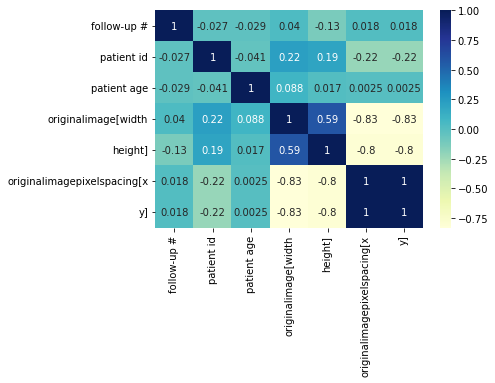

In [78]:
#считаем корреляцию
display('Коэффициенты корреляции:', data.corr())

print(data.corr())
dataplot = sns.heatmap(data.corr(), cmap="YlGnBu", annot=True)
plt.show()

**Наблюдения**

*   Скорррелированными признаками являются только те, которые обозначают параметры изображения. Эти признаки:
    - originalimage[width,
    - height],
    - originalimagepixelspacing[x,
    - y].

### Исследование распределений

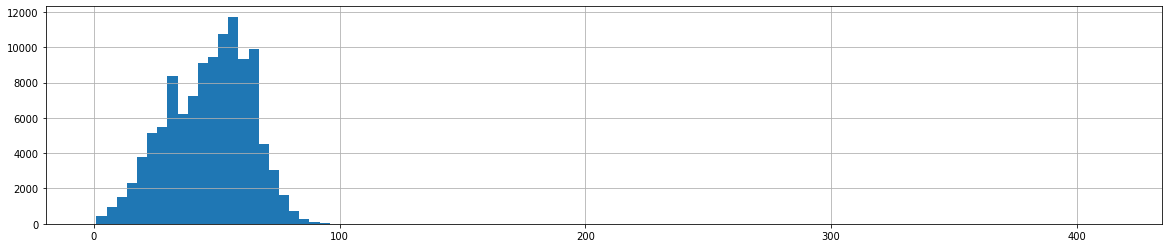

In [79]:
plt.figure(figsize=(20, 4))
data['patient age'].hist(bins=100)

**Наблюдения**

*   На графике изображено нормальное распределение наблюдений по возрасту с левосторонней асимметрией.
*   Из-за наличия выбросов график имеет длинный, но неразличимый хвост справа.

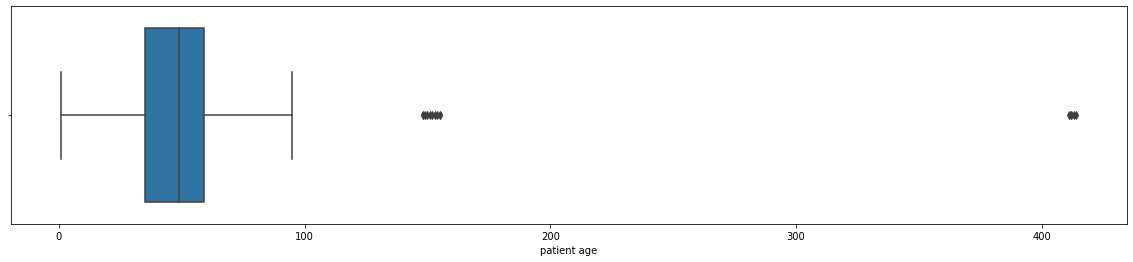

In [22]:
# строим boxplot по признаку возраста для визуализации выбросов
plt.figure(figsize=(20, 4))
sns.boxplot(x=data['patient age'])

In [23]:
outliers = data[data['patient age'] > 100]
print('Количество выбросов по возрасту:', len(outliers))

Количество выбросов по возрасту: 16


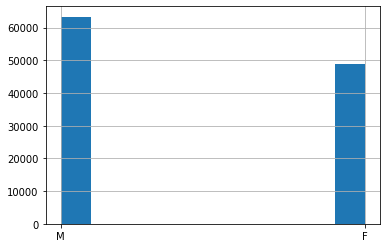

In [24]:
data['patient gender'].hist()

**Наблюдения**

*   В распределении по полу наблюдается больше снимков пациентов мужского пола.

### Выводы

*   Датасет имеет более 100 тысяч наблюдений.
*   Датасет не имеет пропущенных значений или дубликатов. 
*   По признаку "возраст пациента" наблюдаются выбросы со значениями до 414, которые впоследствие будут отброшены. В целом этот признак имеет нормальное распределение с левосторонней асимметрией.
*   Признак "Finding Labels" содержит строковый тип данных, что приводит к необходимости кодирования этих категорий в дальнейшем анализе.

## Изучение изображений

In [80]:
img_folder = r'/content/data/images_001/images'

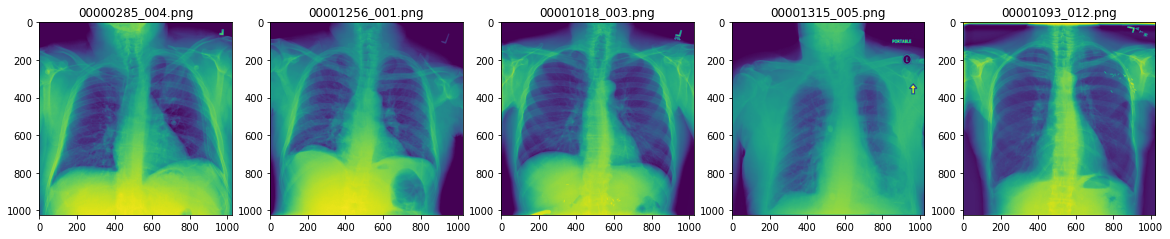

In [81]:
plt.figure(figsize=(20,20))

for i in range(5):
    file = random.choice(os.listdir(img_folder))
    image_path= os.path.join(img_folder, file)
    img = mpimg.imread(image_path)
    ax = plt.subplot(1,5,i+1)
    ax.title.set_text(file)
    plt.imshow(img)

## Исследовательский анализ данных

### Image Index

**Индекс изображения** имеет следующий формат 00000001_000.png. Число перед подчеркиванием соответствует идентификатору пациента, а число после подчеркивания — номеру изображения (в зависимости от идентификатора пациента).


Все изображения хранятся в формате _**PNG**_. Поскольку изображения PNG имеют более высокое качество, чем изображения **_JPEG_**, они занимают больше памяти.
Это необходимо иметь в виду при разработке модели.
____


### Finding Labels

Всего 15 классов (14 болезней и один для "No findings").
В следующей ячейке показано, что в наборе данных имеется 209 уникальных комбинаций уникальных лейблов + комбинации лейблов.

Если метки разделены и упорядочены в алфавитно-цифровом порядке, количество уникальных пар изменится. т.е. "Pneumonia|Effusion" должен быть помечен так же, как "Effusion|Pneumonia".

____

In [82]:
print("Unique Combinations Before Transformation: ", data["finding labels"].nunique())

data["finding labels"] = data["finding labels"].str.split("|").apply(lambda x: sorted(x)).str.join("|")

print("Actual Unique Combinations: ", data["finding labels"].nunique())

Unique Combinations Before Transformation:  836
Actual Unique Combinations:  801


### Follow-up Number

Этот признак является показателем того, какой по счету раз пациент был осмотрен.


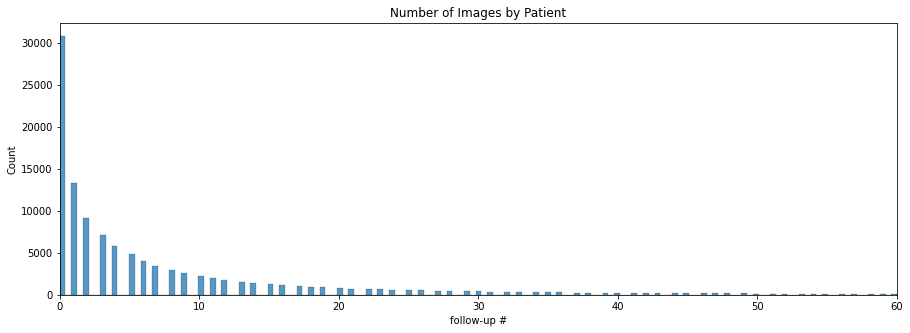

In [84]:
def follow_up_number_p1(df):
    fig, ax = plt.subplots(figsize=(15,5))
    sns.histplot(data=df, x="follow-up #", ax=ax).set_title('Number of Images by Patient')
    plt.xlim(0,60)
    plt.show(sns)

follow_up_number_p1(data)

Как и ожидалось, график сильно перекошен влево, и у большинства пациентов в наборе данных менее 10 изображений. При этом есть выбросы до нескольких десятков раз.

### Кодирование патологий

Для работы с визуализаций распределений по типу патологии необходимо провести кодирование признака "finding labels". 

In [85]:
# создаем список с названиями всех уникальных лейблов
labels_list = data['finding labels'].unique()
uniq_labels_list = [*filter(lambda x: '|' not in x, labels_list)]

# создаем таблицу с лейблами, заполненную нулями
empty_dum = pd.DataFrame(np.zeros(
    (
    data.shape[0], len(uniq_labels_list))
    )
).astype('int')
column_names = {el:lab for el, lab in zip(
    range(len(uniq_labels_list)
    ), uniq_labels_list)}
empty_dum = empty_dum.rename(columns=column_names)

In [86]:
# кодирование для уникальных лейблов
data_encod = data.copy()
data_encod = pd.concat([data_encod, empty_dum], axis=1)
for n in range(data_encod.shape[0]):
    row_label = data_encod.loc[n]['finding labels']
    if '|' in str(row_label):
        multi_label = row_label.split('|')
        for label in multi_label:
            data_encod[label].loc[n] = 1
    else:
        data_encod[row_label].loc[n] = 1

display(data_encod)

/usr/local/lib/python3.8/dist-packages/pandas/core/indexing.py:1732: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_block(indexer, value, name)


,image index,finding labels,follow-up #,patient id,patient age,patient gender,view position,originalimage[width,height],originalimagepixelspacing[x,...,Emphysema,Effusion,Atelectasis,Pleural_Thickening,Pneumothorax,Mass,Fibrosis,Consolidation,Edema,Pneumonia
0,00000001_000.png,Cardiomegaly,0,1,58,M,PA,2682,2749,0.143,...,0,0,0,0,0,0,0,0,0,0
1,00000001_001.png,Cardiomegaly|Emphysema,1,1,58,M,PA,2894,2729,0.143,...,1,0,0,0,0,0,0,0,0,0
2,00000001_002.png,Cardiomegaly|Effusion,2,1,58,M,PA,2500,2048,0.168,...,0,1,0,0,0,0,0,0,0,0
3,00000002_000.png,No Finding,0,2,81,M,PA,2500,2048,0.171,...,0,0,0,0,0,0,0,0,0,0
4,00000003_000.png,Hernia,0,3,81,F,PA,2582,2991,0.143,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
112115,00030801_001.png,Mass|Pneumonia,1,30801,39,M,PA,2048,2500,0.168,...,0,0,0,0,0,1,0,0,0,1
112116,00030802_000.png,No Finding,0,30802,29,M,PA,2048,2500,0.168,...,0,0,0,0,0,0,0,0,0,0
112117,00030803_000.png,No Finding,0,30803,42,F,PA,2048,2500,0.168,...,0,0,0,0,0,0,0,0,0,0
112118,00030804_000.png,No Finding,0,30804,30,F,PA,2048,2500,0.168,...,0,0,0,0,0,0,0,0,0,0


### Распределение патологий

In [87]:
# посмотрим на самые частые лейблы
uniq_labels_dict = {lab:0 for lab in uniq_labels_list}
for label in uniq_labels_list:
    uniq_labels_dict[label] = sum(data_encod.loc[:, label])

most_common = pd.DataFrame(uniq_labels_dict.items(), columns=['label', 'count'])
most_common = most_common.sort_values(by='count', ascending=False)
print(most_common)
print(most_common.info())

                 label  count
1           No Finding  60361
3         Infiltration  19894
6             Effusion  13317
7          Atelectasis  11559
4               Nodule   6331
10                Mass   5782
9         Pneumothorax   5302
12       Consolidation   4667
8   Pleural_Thickening   3385
0         Cardiomegaly   2776
5            Emphysema   2516
13               Edema   2303
11            Fibrosis   1686
14           Pneumonia   1431
2               Hernia    227
<class 'pandas.core.frame.DataFrame'>
Int64Index: 15 entries, 1 to 2
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   label   15 non-null     object
 1   count   15 non-null     int64 
dtypes: int64(1), object(1)
memory usage: 360.0+ bytes
None


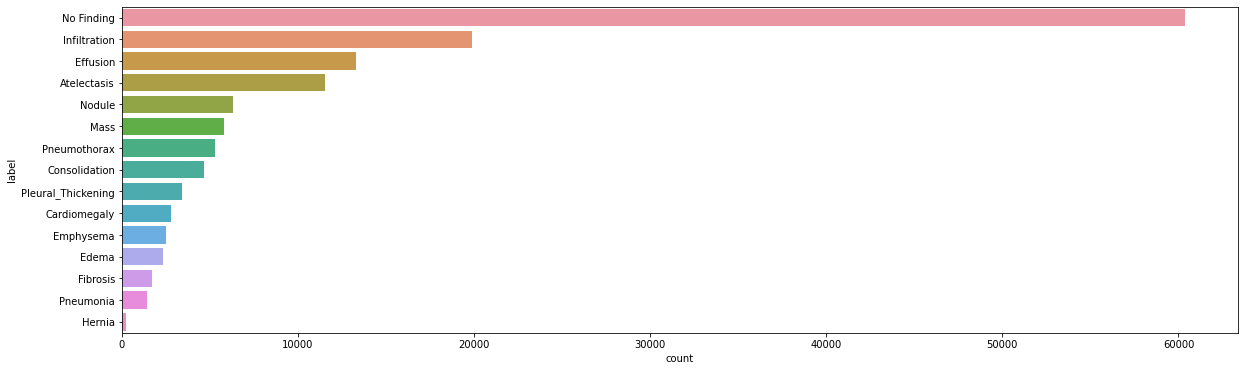

In [88]:
fig, ay = plt.subplots(figsize=(20, 6))
sns.barplot(data=most_common, y=most_common['label'], x=most_common['count'])

(array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13]),
 <a list of 14 Text major ticklabel objects>)

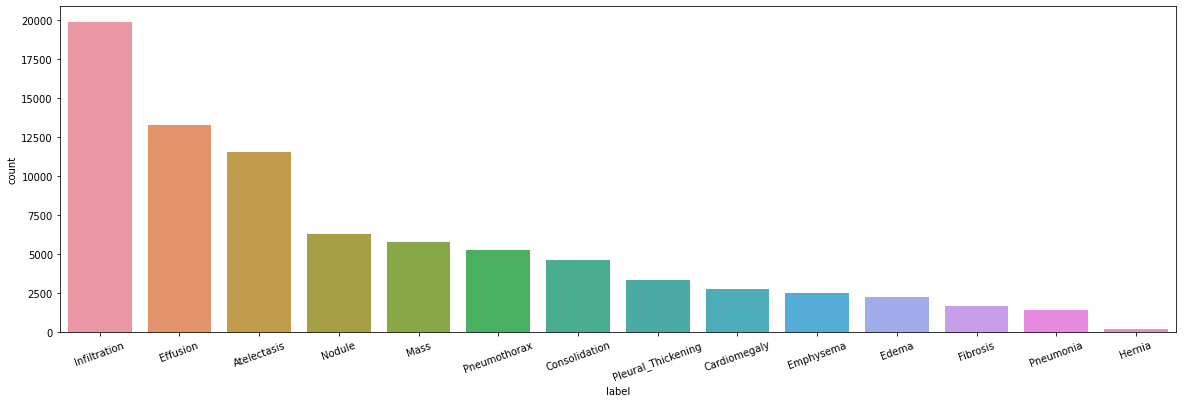

In [89]:
# больше всего здоровых людей, посмотрим распределение без них
common_patology = most_common[1:]
fig, ay = plt.subplots(figsize=(20, 6))
sns.barplot(data=common_patology, y=common_patology['count'], x=common_patology['label'])
plt.xticks(rotation=20)

In [90]:
common_labels = list(most_common['label'])

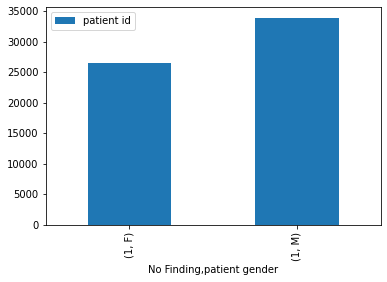

patient id
No Finding patient gender            
1          F                    26439
           M                    33922

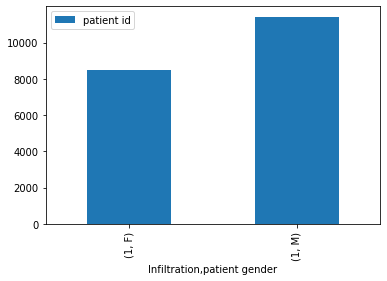

patient id
Infiltration patient gender            
1            F                     8467
             M                    11427

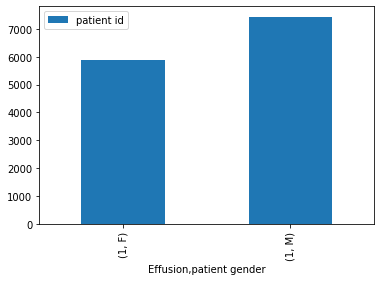

patient id
Effusion patient gender            
1        F                     5882
         M                     7435

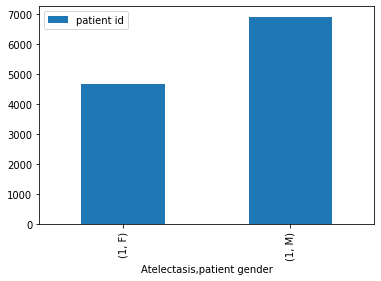

patient id
Atelectasis patient gender            
1           F                     4653
            M                     6906

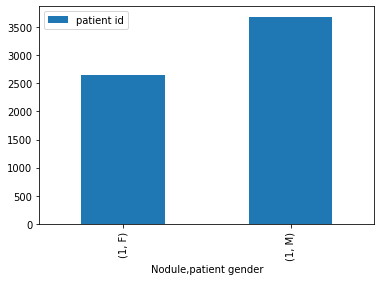

patient id
Nodule patient gender            
1      F                     2646
       M                     3685

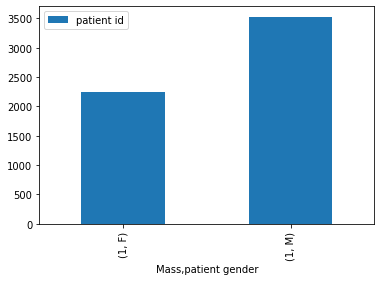

patient id
Mass patient gender            
1    F                     2253
     M                     3529

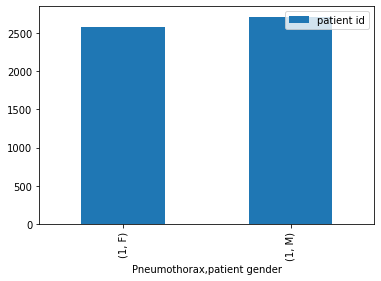

patient id
Pneumothorax patient gender            
1            F                     2585
             M                     2717

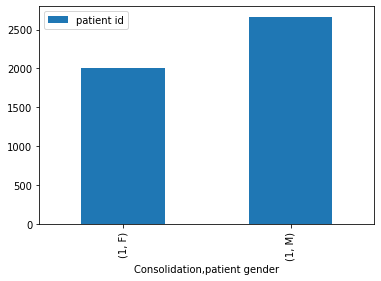

patient id
Consolidation patient gender            
1             F                     2001
              M                     2666

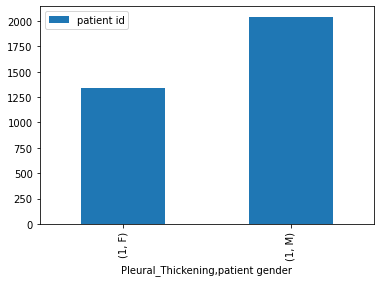

patient id
Pleural_Thickening patient gender            
1                  F                     1343
                   M                     2042

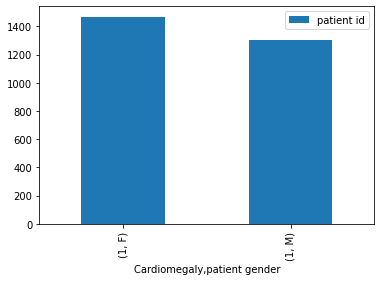

patient id
Cardiomegaly patient gender            
1            F                     1469
             M                     1307

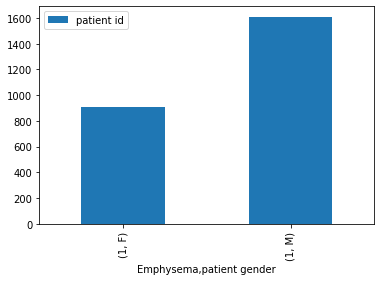

patient id
Emphysema patient gender            
1         F                      906
          M                     1610

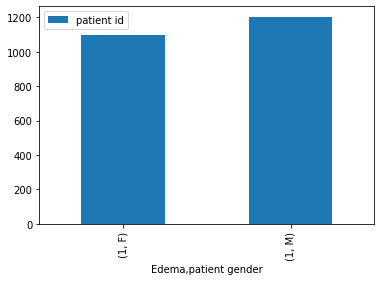

patient id
Edema patient gender            
1     F                     1099
      M                     1204

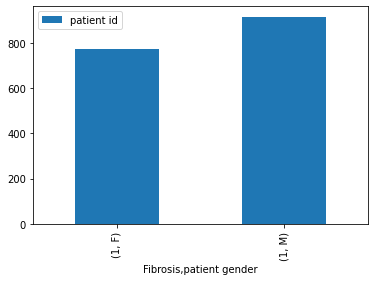

patient id
Fibrosis patient gender            
1        F                      771
         M                      915

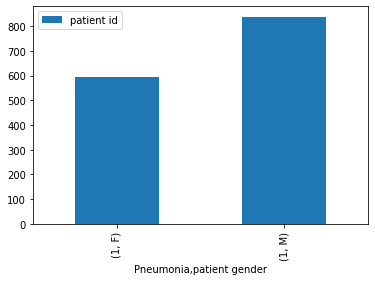

patient id
Pneumonia patient gender            
1         F                      593
          M                      838

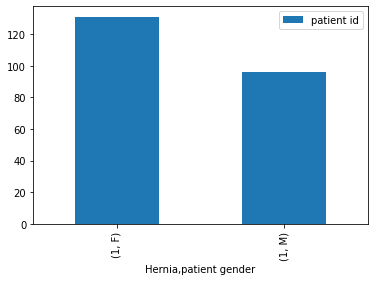

patient id
Hernia patient gender            
1      F                      131
       M                       96

In [91]:
# посмотрим разбивку лейблов по полу
for label in common_labels:
    label_gender_pivot = (pd.pivot_table(data_encod[data_encod[label] == 1],
                          index = [label,'patient gender'],
                          values = 'patient id',
                          aggfunc = 'count'))
    label_gender_pivot.plot(kind='bar')
    plt.show()
    display(label_gender_pivot)

In [92]:
genders = data_encod['patient gender'].value_counts()
genders

M    63340
F    48780
Name: patient gender, dtype: int64

**Наблюдения:**

*   Почти по всех случаях наблюдается преобладание количества наблюдений у пациентов мужского пола.
*   Исключениями являются кардиомегалия и грыжа, где преобладающей группой являются женщины.

### Граф встречаемости патологий

Чтобы проанализировать, какие патологические состояния встречаются вместе чаще других, построим граф, где чем чаще патологии встречаются вместе, тем ближе они располагаются друг к другу.

In [93]:
label_dummies = data_encod.iloc[:, 11:26]
label_dummies = label_dummies.drop('No Finding', axis=1)
label_dummies = label_dummies.reset_index(drop=True)

# создадим таблицу совместного появления лейблов
matrix = label_dummies.to_numpy()
adjacency_matrix = matrix.T @ matrix

network_data = pd.DataFrame(adjacency_matrix)
pathology_names = list(label_dummies.columns)
network_data.index = pathology_names
network_data.columns = pathology_names

display(network_data)

,Cardiomegaly,Hernia,Infiltration,Nodule,Emphysema,Effusion,Atelectasis,Pleural_Thickening,Pneumothorax,Mass,Fibrosis,Consolidation,Edema,Pneumonia
Cardiomegaly,2776,7,587,108,44,1063,370,111,49,102,52,169,127,41
Hernia,7,227,33,10,4,21,40,8,9,25,8,4,3,3
Infiltration,587,33,19894,1546,449,4000,3264,750,946,1159,345,1221,981,605
Nodule,108,10,1546,6331,115,912,590,411,341,906,166,428,131,70
Emphysema,44,4,449,115,2516,359,424,151,747,215,36,103,30,23
Effusion,1063,21,4000,912,359,13317,3275,849,996,1254,188,1287,593,269
Atelectasis,370,40,3264,590,424,3275,11559,496,774,739,220,1223,221,262
Pleural_Thickening,111,8,750,411,151,849,496,3385,289,452,176,251,64,48
Pneumothorax,49,9,946,341,747,996,774,289,5302,431,80,223,33,41
Mass,102,25,1159,906,215,1254,739,452,431,5782,117,610,129,71


In [94]:
# получим таблицу весов для будущего графа

weights = network_data.stack()
weights = weights[weights >= 1].rename_axis(
        ('source', 'target')
    ).reset_index(name='weight')
weights = weights[weights['source'] != weights['target']]

display(weights)

,source,target,weight
1,Cardiomegaly,Hernia,7
2,Cardiomegaly,Infiltration,587
3,Cardiomegaly,Nodule,108
4,Cardiomegaly,Emphysema,44
5,Cardiomegaly,Effusion,1063
...,...,...,...
190,Pneumonia,Pneumothorax,41
191,Pneumonia,Mass,71
192,Pneumonia,Fibrosis,11
193,Pneumonia,Consolidation,123


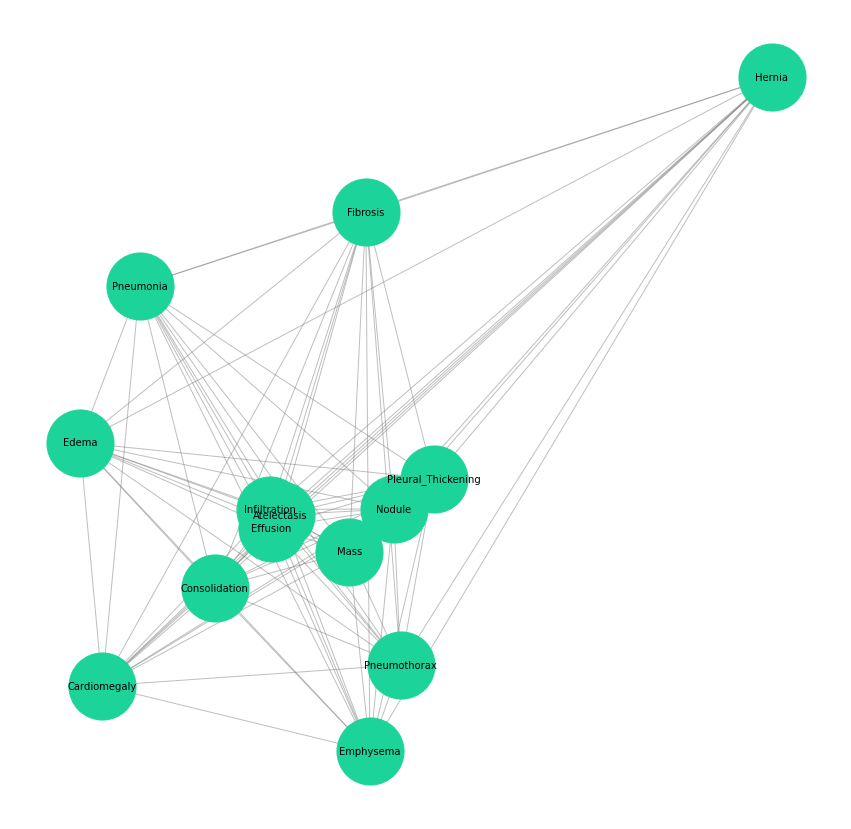

In [95]:
# строим граф
G = nx.from_pandas_edgelist(weights, edge_attr=True)
plt.figure(figsize=(15,15), facecolor='white')
pos = nx.spring_layout(G, k=0.1)

nx.draw_networkx_nodes(G, pos, node_color='#1cd499', node_size=4500)
nx.draw_networkx_labels(G, pos, font_size=10)
nx.draw_networkx_edges(G, pos, alpha=0.5, edge_color='grey')

plt.axis('off')
plt.show()

**Наблюдения:**

Патологии, которые часто встречаются совместно:

*   ателектаз, инфильтрация, плевральный выпот.

Реже других встречаются совместно с чем-либо:

*   грыжа;
*   фиброз.

### Распределение возраста

Из логических соображений и по ранее построенному boxplot удаляем те наблюдения, где возраст пациента > 100.

In [96]:
data = data[data["patient age"] <= 100]
data_encod = data_encod[data_encod["patient age"] <= 100]

In [97]:
# сравним возраст больных и здоровых
healthy = data_encod[data_encod['finding labels'] == 'No Finding']
ill = data_encod[data_encod['finding labels'] != 'No Finding']

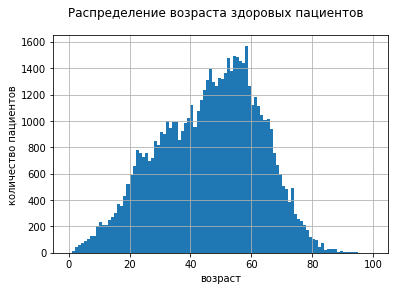

In [98]:
healthy['patient age'].hist(bins=100, range=(0, 100))
plt.suptitle("Распределение возраста здоровых пациентов")
plt.xlabel("возраст")
plt.ylabel("количество пациентов")
plt.show()

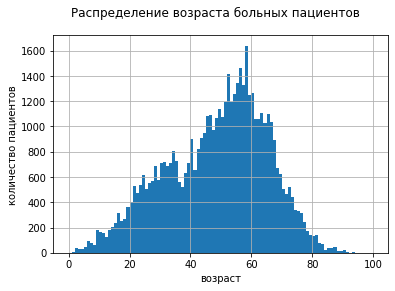

In [99]:
ill['patient age'].hist(bins=100, range=(0, 100))
plt.suptitle("Распределение возраста больных пациентов")
plt.xlabel("возраст")
plt.ylabel("количество пациентов")
plt.show()

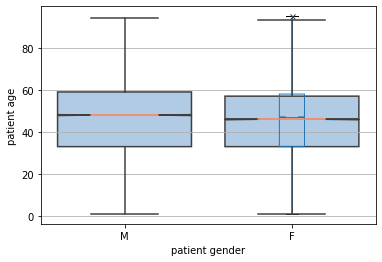

In [100]:
# Сравним здоровых мужчин и женщин
healthy.boxplot(column='patient age', notch=True)
sns.boxplot(
    data=healthy, x="patient gender", y="patient age",
    notch=True, showcaps=True,
    flierprops={"marker": "x"},
    boxprops={"facecolor": (.4, .6, .8, .5)},
    medianprops={"color": "coral"},
)

Для того, чтобы посмотреть распределение патологий по возрасту, создадим новый признак возрастной группы.

In [101]:
def create_age_group(row):
    if row['patient age'] <= 16:
        return 'Child'
    if 17 <= row['patient age'] <= 30:
        return 'Early Adulthood'
    if 31 <= row['patient age'] <= 45:
        return 'Early Middle Age'
    if 46 <= row['patient age'] <= 59:
        return 'Late Middle Age'
    if row['patient age'] >= 60:
        return 'Late Adulthood'

In [102]:
data_encod = data_encod.reset_index(drop=True)
data_encod['age_group'] = data_encod.apply(lambda row: create_age_group(row), axis=1)

Late Middle Age     36959
Late Adulthood      27032
Early Middle Age    26860
Early Adulthood     16617
Child                4636
Name: age_group, dtype: int64


[Text(0, 0, 'Child'),
 Text(0, 0, 'Early Adulthood'),
 Text(0, 0, 'Early Middle Age'),
 Text(0, 0, 'Late Adulthood '),
 Text(0, 0, 'Late Middle Age')]

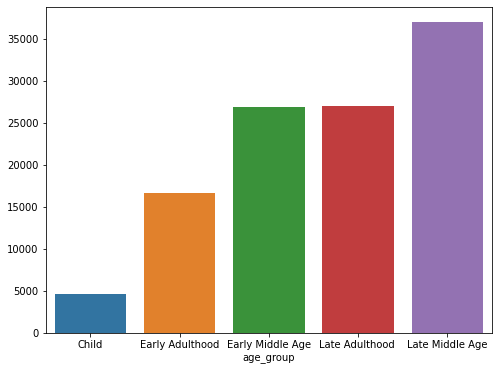

In [103]:
# посмотрим общее распределение возрастных групп

common_ages = data_encod['age_group'].value_counts().sort_values(ascending=False)
print(common_ages)

fig, ay = plt.subplots(figsize=(8, 6))
sns.barplot(data=common_ages, y=common_ages.values, x=common_ages.index)
ay.set_xticklabels(['Child',
                   'Early Adulthood',
                   'Early Middle Age',
                   'Late Adulthood ',
                   'Late Middle Age'])

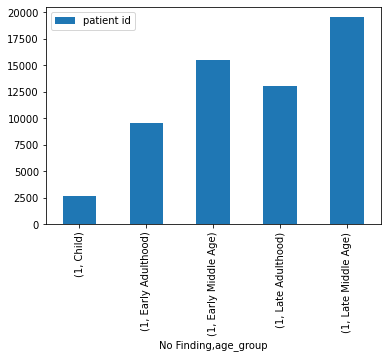

patient id
No Finding age_group                   
1          Child                   2692
           Early Adulthood         9577
           Early Middle Age       15470
           Late Adulthood         13087
           Late Middle Age        19527

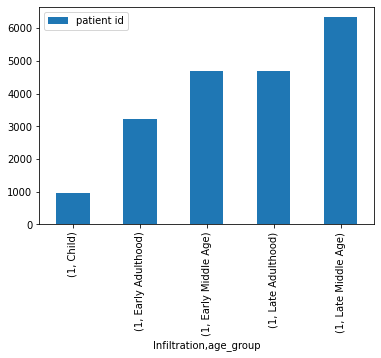

patient id
Infiltration age_group                   
1            Child                    974
             Early Adulthood         3207
             Early Middle Age        4698
             Late Adulthood          4681
             Late Middle Age         6331

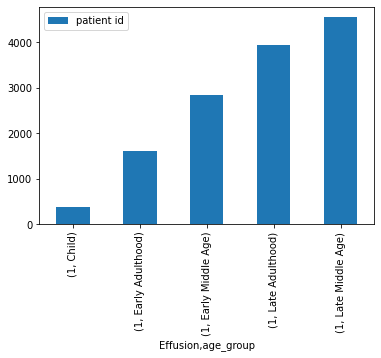

patient id
Effusion age_group                   
1        Child                    383
         Early Adulthood         1605
         Early Middle Age        2836
         Late Adulthood          3943
         Late Middle Age         4549

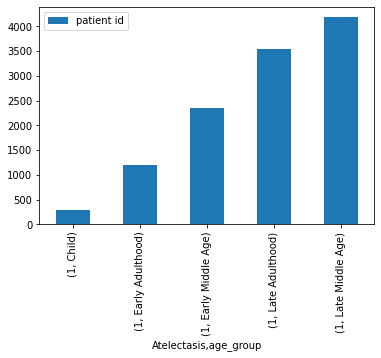

patient id
Atelectasis age_group                   
1           Child                    296
            Early Adulthood         1195
            Early Middle Age        2343
            Late Adulthood          3540
            Late Middle Age         4184

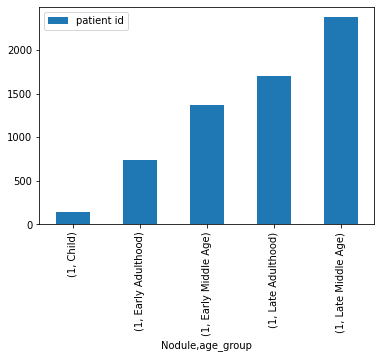

patient id
Nodule age_group                   
1      Child                    144
       Early Adulthood          741
       Early Middle Age        1369
       Late Adulthood          1701
       Late Middle Age         2376

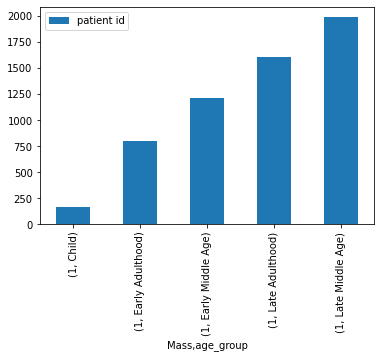

patient id
Mass age_group                   
1    Child                    166
     Early Adulthood          802
     Early Middle Age        1212
     Late Adulthood          1610
     Late Middle Age         1989

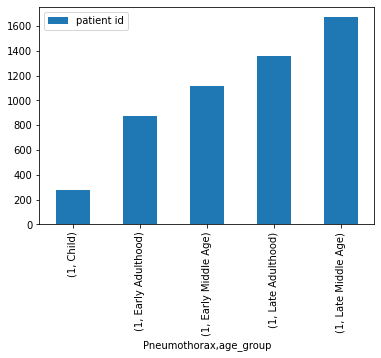

patient id
Pneumothorax age_group                   
1            Child                    278
             Early Adulthood          876
             Early Middle Age        1117
             Late Adulthood          1359
             Late Middle Age         1671

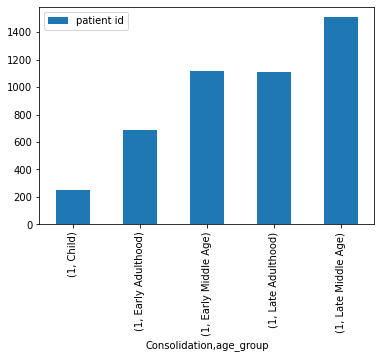

patient id
Consolidation age_group                   
1             Child                    247
              Early Adulthood          684
              Early Middle Age        1115
              Late Adulthood          1113
              Late Middle Age         1508

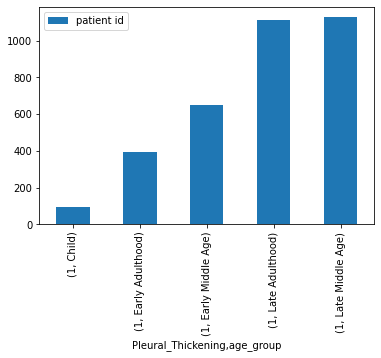

patient id
Pleural_Thickening age_group                   
1                  Child                     97
                   Early Adulthood          395
                   Early Middle Age         651
                   Late Adulthood          1114
                   Late Middle Age         1127

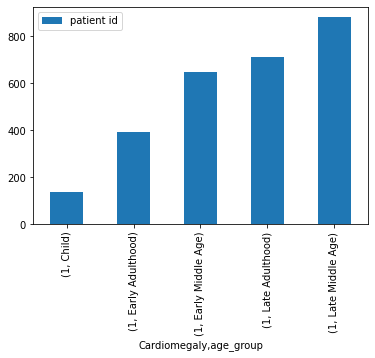

patient id
Cardiomegaly age_group                   
1            Child                    139
             Early Adulthood          395
             Early Middle Age         649
             Late Adulthood           712
             Late Middle Age          881

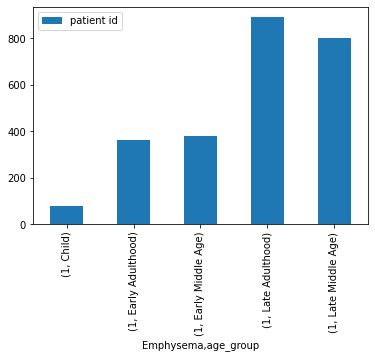

patient id
Emphysema age_group                   
1         Child                     80
          Early Adulthood          362
          Early Middle Age         380
          Late Adulthood           891
          Late Middle Age          803

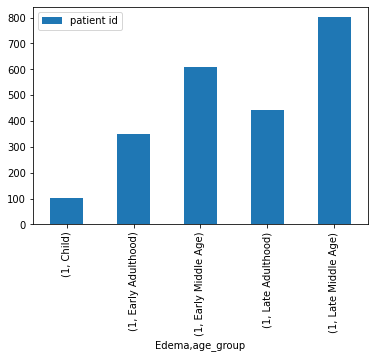

patient id
Edema age_group                   
1     Child                    103
      Early Adulthood          349
      Early Middle Age         607
      Late Adulthood           442
      Late Middle Age          801

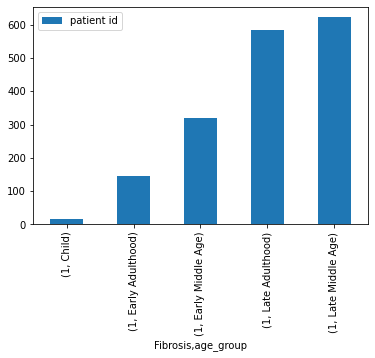

patient id
Fibrosis age_group                   
1        Child                     16
         Early Adulthood          144
         Early Middle Age         319
         Late Adulthood           585
         Late Middle Age          622

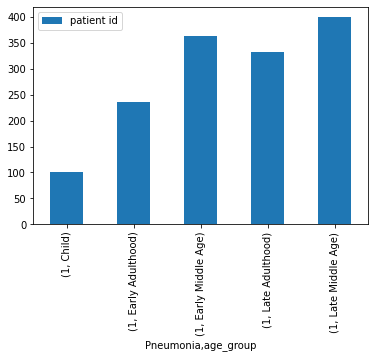

patient id
Pneumonia age_group                   
1         Child                    100
          Early Adulthood          236
          Early Middle Age         363
          Late Adulthood           332
          Late Middle Age          399

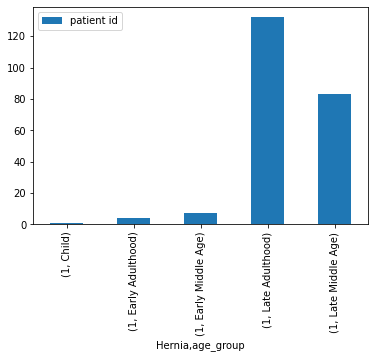

patient id
Hernia age_group                   
1      Child                      1
       Early Adulthood            4
       Early Middle Age           7
       Late Adulthood           132
       Late Middle Age           83

In [104]:
# посмотрим разбивку лейблов по возрасту

for label in common_labels:
    label_gender_pivot = (pd.pivot_table(data_encod[data_encod[label] == 1],
                          index = [label, 'age_group'],
                          values = 'patient id',
                          aggfunc = 'count'))
    label_gender_pivot.plot(kind='bar')
    plt.show()
    display(label_gender_pivot)

**Наблюдения:**

*   Почти по всех случаях преобладающей группой является 'Late Middle Age', что соответствует возрасту от 46 до 59 лет. Эта группа также является преобладающей во всем датасете.
*   Исключениями являются эмфизема и грыжа, где преобладающей группой является 'Late Adulthood' (старше 60 лет).

### Выводы

*   Среди патологий самыми часто встречаемыми являются инфильтрация, плевральный выпот и ателектаз.
*   Наибольшее число наблюдений характерно для пациентов без какой-либо патологии.
*   Среди патологических состояний выделяются кардиомегалия и грыжа, где количество наблюдений больше у пациентов женского пола (в отличие от противоположной ситуации, когда количество пациентов мужского пола больше, характерной для большинства рассматриваемых патологий).



## Статистический анализ данных

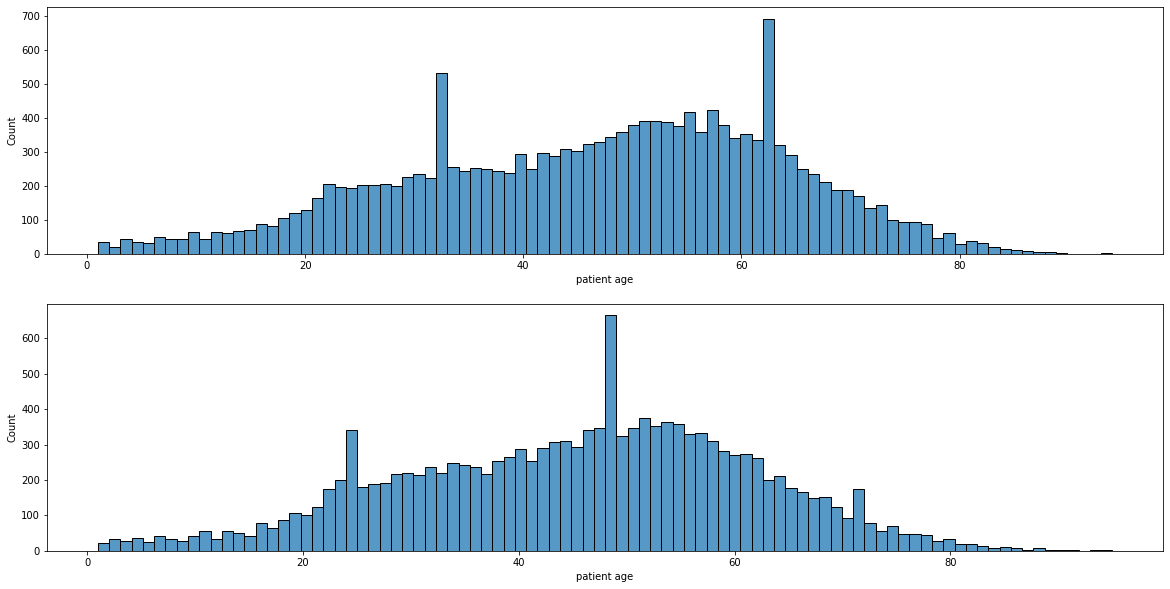

In [105]:
# Как меняется распределение возраста по полу?
# У пациентов с большей вероятностью будет диагностирован определенный лейбл в более поздних наблюдениях(follow-up)?

def age_by_gender_p1(df):
    test = df.groupby("patient id").agg('first')
    fig, axes = plt.subplots(2,1,figsize=(20,10))

    for i, val in enumerate(["M","F"]):
        test1 = test[test['patient gender'] == val].reset_index()
        sns.histplot(test1, x="patient age", ax=axes[i], bins=90)

    plt.show(sns)


age_by_gender_p1(data)

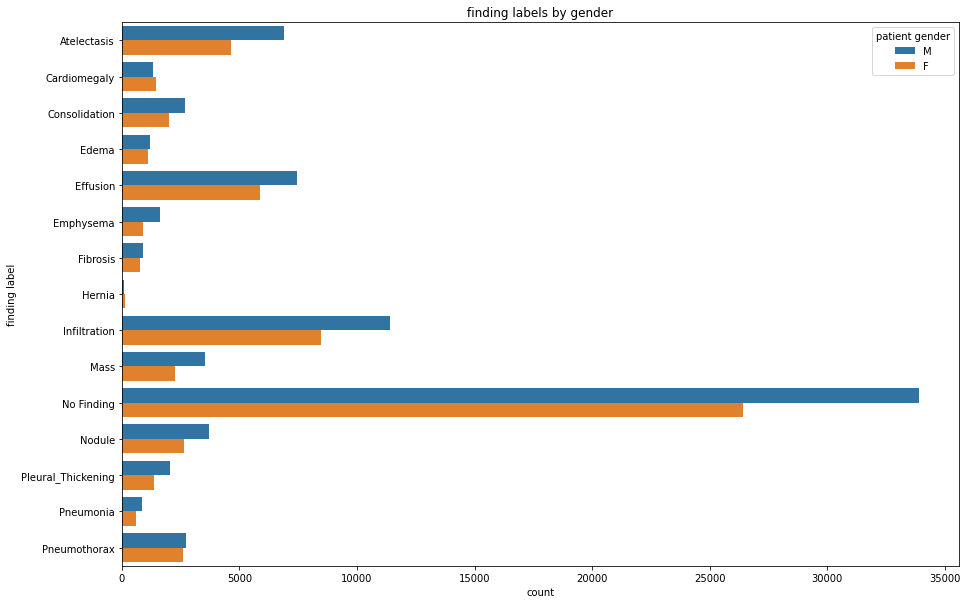

In [106]:
def labels_by_gender_p1(df):
    test = df.assign(var1=df['finding labels'].str.split('|')).explode('var1')
    plot_df = pd.DataFrame()

    for val in ["M", "F"]:
        test1 = test[test["patient gender"] == val].reset_index(drop=True)
        test1 = test1.groupby("var1").size().sort_index().reset_index(name="count")
        test1["patient gender"] = val

        plot_df = pd.concat([plot_df, test1]).reset_index(drop=True)

    plt.figure(figsize=(15, 10))
    plt.title("finding labels by gender")
    ax = sns.barplot(y="var1", hue="patient gender", x="count", data=plot_df, orient = 'h')
    plt.ylabel("finding label")
    plt.show(sns)


labels_by_gender_p1(data)

Кардиомегалия и плевральный выпот - единственные лейблы, на которых больше изображений пациентов женского пола.

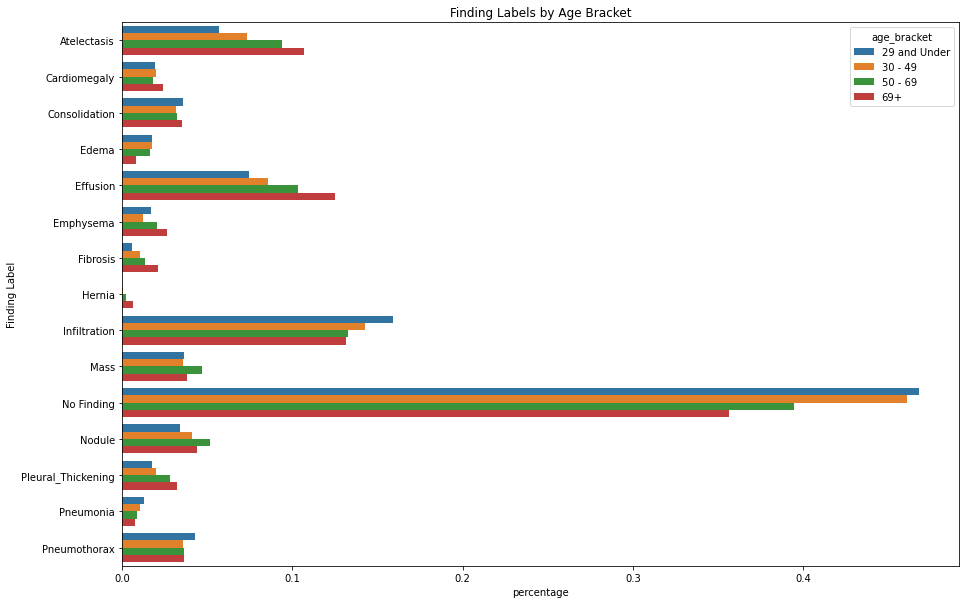

In [107]:
# Распределение лейблов по возрасту

def labels_by_age_p1(df):
    test = df.assign(var1=df['finding labels'].str.split('|')).explode('var1')

    conditions = [
        (test['patient age'] <= 29),
        (test['patient age'] >= 30) & (test['patient age'] <= 49),
        (test['patient age'] >= 50) & (test['patient age'] <= 69),
        (test['patient age'] >= 60)
    ]

    choices = ['29 and Under', '30 - 49', '50 - 69', '69+']
    test['age_bracket'] = np.select(conditions, choices, default=np.nan)
    test1 = test.groupby(["age_bracket", "var1"]).size().sort_index().reset_index(name="count")
    test2 = test1.groupby("age_bracket").sum("count").reset_index()

    test1 = test1.merge(test2, on='age_bracket', suffixes=('', '_total'))
    test1["percentage"] = test1["count"]/test1["count_total"]

    plt.figure(figsize=(15, 10))
    plt.title("Finding Labels by Age Bracket")
    ax = sns.barplot(y="var1", hue="age_bracket", x="percentage", data=test1, orient = 'h')
    plt.ylabel("Finding Label")
    plt.show(sns)
    
    
labels_by_age_p1(data)

У пациентов в возрасте до 29 лет вероятность развития пневмоторакса, инфильтрации или отсутствия какой-либо патологии - выше, чем у остальной части населения.
_______

Пациенты старше 69 лет чаще имеют утолщение плевры, фиброз, грыжу, эмфизему, выпот, кардиомегалию и ателектаз, чем другие возрастные группы.
_______
Пациенты в возрастной группе от 30 до 49 лет постоянно находятся в середине группы, но занимают второе место в категориях отеков и кардиомегалии.
______
У пациентов в возрастной группе 50–69 лет чаще, чем в других возрастных группах, обнаруживается увеличение лимфатических узлов.

______
**Отсутствие какой либо патологии чаще встречается у пациентов возрастной группы до 29 лет**

<ipython-input-108-2da08206b45f>:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df["tags"] = df["finding labels"].str.split("|")
<ipython-input-108-2da08206b45f>:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df["tags"] = df["tags"].apply(lambda x: sorted(x))


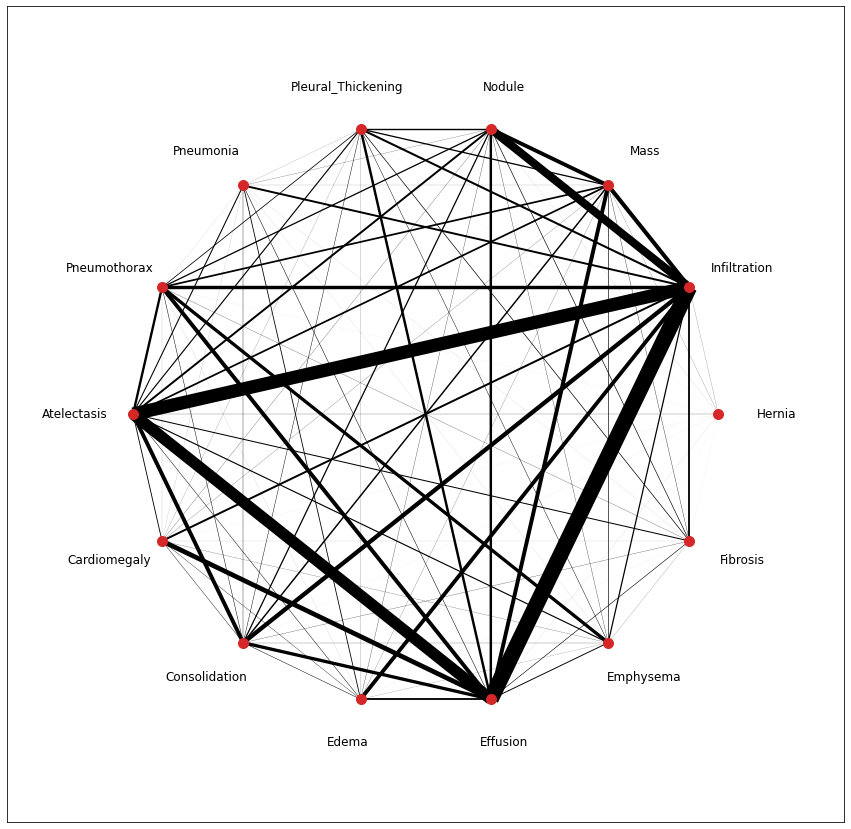

In [108]:
# Лейблы, которые чаще встречаются вместе

def label_groups_p2(df):
    df = df[df["finding labels"].str.count(r'\|') == 1]
    df["tags"] = df["finding labels"].str.split("|")
    df["tags"] = df["tags"].apply(lambda x: sorted(x))

    all_tags = np.unique(np.concatenate(df['tags'].values))
    all_tags

    def add_edge_weight(head, tail):
        try:
            weight = G[head][tail]['weight']
        except:
            G.add_edge(head, tail, weight=1)
        else:
            G[head][tail]['weight'] += 1

    G = nx.Graph()

    for t in all_tags:
        G.add_node(t)

    for q in df.index:
        tags = df.loc[q, 'tags']
        for i in range(len(tags)-1):
            for j in range(i+1, len(tags)):
                add_edge_weight(tags[i], tags[j])

    plt.figure(figsize=(15,15))
    pos = nx.shell_layout(G)

    w_sum = 0
    for (node1,node2,data) in G.edges(data=True):
        w_sum += data['weight']

    for (node1,node2,data) in G.edges(data=True):
        width = data["weight"]*len(G.nodes)*10.0/w_sum
        nx.draw_networkx_edges(G,pos,edgelist=[(node1, node2)],width=width)

    nx.draw_networkx_nodes(G, pos, node_size=100, node_color='tab:red')

    new_pos = {k: np.asarray([v[0]*1.2, v[1]*1.15]) for k, v in pos.items()}
    nx.draw_networkx_labels(G, new_pos, {n: str(n) for n in list(G.nodes())})
    plt.margins(x=0.15, y=0.15)
    plt.show()
  

label_groups_p2(data)

Этот график показывает, что наиболее частыми являются пары между инфильтрацией-выпотом и ателектазом-выпотом.

Выводы

## Предобработка данных для построения модели

In [109]:
data = data.drop(['originalimage[width',
                 'height]',
                 'originalimagepixelspacing[x',
                 'y]'], axis=1)

In [110]:
data = data[:4999]

In [111]:
# Создаем колонку для подсчета количества нозологий у одного пациента.
data['labels_count'] = data['finding labels'].apply(lambda text: len(text.split('|')) if(text != 'No Finding') else 0)
data['labels_count'].value_counts()

0    2754
1    1421
2     582
3     171
4      58
5      12
6       1
Name: labels_count, dtype: int64

Из-за ограниченности вычислительных мощностей ограничим выборку семплом из 1000 наблюдений.

In [112]:
sample = random.sample(os.listdir(img_folder), 1000)

In [113]:
def create_dataset(img_folder):
    img_data_array = []
    img_name = []
    for file in sample:
        image_path = os.path.join(img_folder, file)
        image = Image.open(image_path)
        sharpness = ImageEnhance.Sharpness(image)
        image = sharpness.enhance(100.0)
        brightness = ImageEnhance.Brightness(image)
        image = brightness.enhance(1.5)
        image = image.convert("1")
        #plt.imshow(image)
        image = np.array(image)
        image = image.astype('float32')
        image /= 255 
        img_data_array.append(image)
        img_name.append(file)
    return img_data_array, img_name

img_data, img_name = create_dataset(r'/content/data/images_001/images')


In [114]:
images_df = pd.DataFrame({'images':img_data, 'image index':img_name})

In [115]:
data_merged = data.merge(images_df, how='inner', on='image index')

In [116]:
display(data_merged.head())

,image index,finding labels,follow-up #,patient id,patient age,patient gender,view position,labels_count,images
0,00000003_000.png,Hernia,0,3,81,F,PA,1,"[[0.0, 0.003921569, 0.0, 0.0, 0.0, 0.0, 0.0, 0..."
1,00000005_002.png,No Finding,2,5,69,F,AP,0,"[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,..."
2,00000005_007.png,Effusion|Infiltration,7,5,70,F,PA,2,"[[0.003921569, 0.003921569, 0.003921569, 0.003..."
3,00000007_000.png,No Finding,0,7,82,M,PA,0,"[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,..."
4,00000009_000.png,Emphysema,0,9,73,M,PA,1,"[[0.003921569, 0.003921569, 0.003921569, 0.003..."


In [117]:
values = data_merged['finding labels'].value_counts()

In [118]:
less_than_two = values[values.values <= 2].index

Чтобы обучить модели, исключим те случаи, где количество наблюдений <= 2.

In [119]:
for i in range(len(data_merged['finding labels'])):
    if data_merged['finding labels'][i] in less_than_two:
        data_merged = data_merged.drop(index=[i])

In [ ]:
data_merged['images'] = tf.convert_to_tensor(data_merged['images'])

In [155]:
target = data_merged['finding labels']
features = data_merged.drop('finding labels', axis=1)

In [156]:
features_train, features_test, target_train, target_test = train_test_split(
    features, target, test_size=0.2, random_state=12345) # разделили выборки в пропорции 2 к 8   

In [157]:
for i in [features_train, features_test, target_train, target_test]:
    print(i.shape)

(729, 8)
(183, 8)
(729,)
(183,)


In [158]:
cat_columns = ['image index','follow-up #', 'patient id', 
               'patient age', 'patient gender', 'view position',
               'labels_count']

In [159]:
lbl = preprocessing.LabelEncoder()

In [160]:
for i in cat_columns:
    data_merged[i] = lbl.fit_transform(data_merged[i].astype(str))

In [161]:
encoder = OrdinalEncoder()
features_train_oe = features_train.copy()
features_train_oe[cat_columns] = encoder.fit_transform(features_train_oe[cat_columns])

In [162]:
RANDOM_STATE = 12345

## Общий вывод

Алгоритм обработки данных и последующий анализ с визуализацией посредством графов позволил определить наиболее сочетающиеся изменения в виде инфильтрации, отека, ателектаза и определения (увеличения) лимфоузлов. Возможно это можно использовать для объединяющей категории признаков свидетельствующих о высокой вероятности воспалительного процесса в легких. 